Exercise 3
=========

In this exercise you should invetigate model order reduction by a modeal basis.
You should be able to re-use many parts from the previous exercises.

Consider the plate clamped at all edges.

In [192]:
from scipy.io import mmread
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import eigsh
from scipy.sparse.linalg import inv

import numpy as np

import matplotlib as matplot
import matplotlib.pyplot as plt
matplot.rcParams.update({'figure.max_open_warning': 0})

# Uncomment the following line and edit the path to ffmpeg if you want to write the video files!
#plt.rcParams['animation.ffmpeg_path'] ='N:\\Applications\\ffmpeg\\bin\\ffmpeg.exe'

from mpl_toolkits.mplot3d import Axes3D

import sys
# np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(threshold=10)

from numpy.fft import rfft, rfftfreq

from utility_functions import Newmark

In [194]:
M = csc_matrix(mmread('Ms.mtx')) # mass matrix
K = csc_matrix(mmread('Ks.mtx')) # stiffness matrix
C = csc_matrix(K.shape) # a zeros damping matrix
X = mmread('X.mtx') # coodinate matrix with columns corresponding to x,y,z position of the nodes

N = X.shape[0] # number of nodes

nprec = 6 # precision for finding uniqe values

# get grid vectors (the unique vectors of the x,y,z coodinate-grid)
x = np.unique(np.round(X[:,0],decimals=nprec))
y = np.unique(np.round(X[:,1],decimals=nprec))
z = np.unique(np.round(X[:,2],decimals=nprec))

# grid matrices
Xg = np.reshape(X[:,0],[len(y),len(x),len(z)])
Yg = np.reshape(X[:,1],[len(y),len(x),len(z)])
Zg = np.reshape(X[:,2],[len(y),len(x),len(z)])

tol = 1e-12

# constrain all edges
Nn = np.argwhere(np.abs(X[:,1]-X[:,1].max())<tol).ravel() # Node indices of N-Edge nodes
No = np.argwhere(np.abs(X[:,0]-X[:,0].max())<tol).ravel() # Node indices of O-Edge nodes
Ns = np.argwhere(np.abs(X[:,1]-X[:,1].min())<tol).ravel() # Node indices of S-Edge nodes
Nw = np.argwhere(np.abs(X[:,0]-X[:,0].min())<tol).ravel() # Node indices of W-Edge nodes

Nnosw = np.unique(np.concatenate((Nn,No,Ns,Nw))) #concatenate all and only take unique (remove the double ones)

# indices of x, y, and z DoFs in the global system
# can be used to get DoF-index in global system, e.g. for y of node n by Iy[n]
Ix = np.arange(N)*3 # index of x-dofs
Iy = np.arange(N)*3+1
Iz = np.arange(N)*3+2

# select which indices in the global system must be constrained
If = np.array([Ix[Nnosw],Iy[Nnosw],Iz[Nnosw]]).ravel() # dof indices of fix constraint
Ic = np.array([(i in If) for i in np.arange(3*N)]) # boolean array of constraind dofs

# compute the reduced system
Kc = csc_matrix(K[np.ix_(~Ic,~Ic)])
Mc = csc_matrix(M[np.ix_(~Ic,~Ic)])
Cc = csc_matrix(C[np.ix_(~Ic,~Ic)])

# Constraint Enforcement
You can enforce contraints as in the previous exercises by selecting the appropriate rows from the system matrices, or use the nullsapce of the constraint matrix.

Set up a constraint matrix and use the provided function for computing the nullspace
```python
from utility_functions import nullspace
```

In [196]:
from utility_functions import nullspace

In [198]:
B = np.zeros((len(If),3*N))
B[np.arange(0,len(If)),np.sort(If)] = 1 #constraint the respective nodes
Q = nullspace(B) #build the nullspace

In [200]:
# Calc constraint matrixes
# Q = csc_matrix(Q) #or make Q also a sparse and go with that
# K_bar = Q.transpose() @ K @ Q
# M_bar = Q.transpose() @ M @ Q
# C_bar = Q.transpose() @ C @ Q

# Mode Shapes
Compute a set of mode-shapes of the system.

#### Note
We now use the sparse system because it's many times faster, however, one can just check the solution of the constraint system with the nullspace by enabling the code-lines and comparing it to the sparse solution.

In [202]:
# only compute a subset of modes of the reduced model
k = 10
Wc,Vc = eigsh(Kc,k,Mc,sigma=0,which='LM',maxiter = 1000)

V = np.zeros([3*N,k])
V[~Ic,:] = Vc

In [204]:
# only compute a subset of modes of the reduced model
# k = 10
# W,V = eigsh(K_bar,k,M_bar,sigma=0,which='LM',maxiter = 1000)

## Modal mass participation factor

Compute the modal mass participation factor for all 6  for the first 10 modes of the plate.

First you need to define the ridig body degrees of freedom (3 displacements and 3 rotations) in terms of displacement fields (can be seen as "mode shapes").

In [206]:
W_unconstrained,V_unconstrained = eigsh(K,k,M,sigma=0,which='LM',maxiter = 1000)

In [208]:
def MPF(vi,M,ej) :
    return np.abs((vi @ M @ ej) / (vi @ M @ vi.transpose()))

In [210]:
def plotMPF(ej, title) :
    dependency = np.zeros(k)
    for i,v in enumerate(V.T) :
        dependency[i] = MPF(v, M, ej)
        
    x = range(len(dependency))
    width = 0.75
    plt.bar(x, dependency, width, color="blue")
    plt.ylabel('Measure of coincidance')
    plt.xlabel('Mode index')
    plt.title(title)
    plt.show()

Then compute the 6 modal mass participation factors for each mode.
Which ridid body displacement is most represented in which mode?

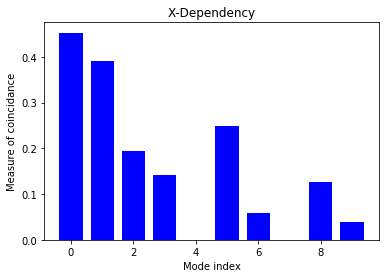

In [212]:
plotMPF(V_unconstrained[:,0],"X-Dependency")

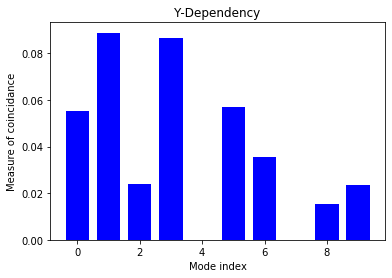

In [214]:
plotMPF(V_unconstrained[:,1],"Y-Dependency")

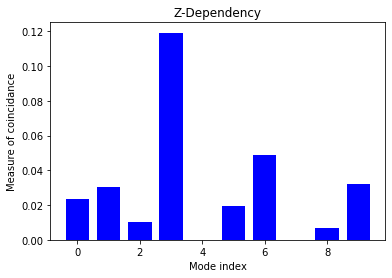

In [216]:
plotMPF(V_unconstrained[:,2],"Z-Dependency")

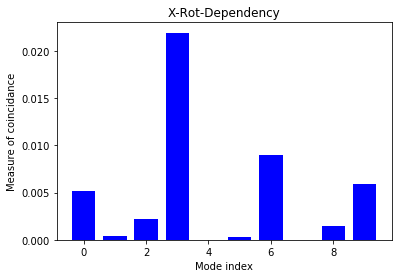

In [218]:
plotMPF(V_unconstrained[:,3],"X-Rot-Dependency")

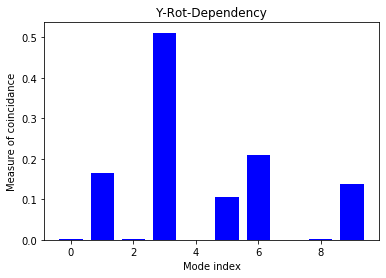

In [220]:
plotMPF(V_unconstrained[:,4],"Y-Rot-Dependency")

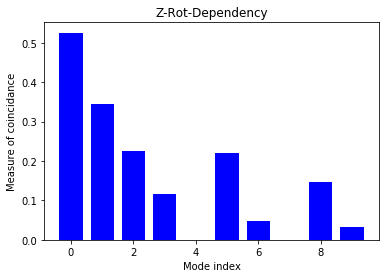

In [222]:
plotMPF(V_unconstrained[:,5],"Z-Rot-Dependency")

In [224]:
# OLD STUFF

# # Define rigid body displacements
# e_x = np.zeros(3*N)
# e_x[Ix] = 1

# e_y = np.zeros(3*N)
# e_y[Iy] = 1

# e_z = np.zeros(3*N)
# e_z[Iz] = 1

# Center = np.array([0., 0., 0.])
# radius = np.zeros(len(X))
# for i in range(len(X)) :
#     radius[i] = np.linalg.norm(Center - [X[i,:]] )

# # Rotation arround the x-axis
# e_rx = np.zeros(3*N)
# e_rx[Ix] = radius

# e_ry = np.zeros(3*N)
# e_ry[Iy] = radius

# e_rz = np.zeros(3*N)
# e_rz[Iz] = radius

# def rotationVector(id_axis) :
#     Center = np.array([0., 0., 0.])
#     rot = np.zeros([beam.nDof,1])

#     radius = np.zeros([len(beam.X),1])
#     for i in range(len(beam.X)) :
#         radius[i,0] = np.linalg.norm(Center - [beam.X[i,:]] )
#     rot[id_axis] = -1*radius
#     return rot

# Static Deformation

Check your bondary conditions by computing a static deformation: Assume a pressure acting on the plate (in transverse =z direction) which is linearly increasing from zero at one short edge (e.g. $x=x_{\min}$) to the oppsite edge. 
Assume a maximal pressure of 10kPa.
For the sake of simplicity you can apply the pressure to one "node layer" (in thichness direction).
Force per node can be obtained by multiplying by the "nodal area", i.e. the total area of the plate divided by the number of nodes in the "node layer".

In [348]:
# Node groups
tol = 1E-12
N_bot = np.argwhere(np.abs(X[:,2]-X[:,2].min())<tol).ravel() # Node indices of bottom nodes 
N_top = np.argwhere(np.abs(X[:,2]-X[:,2].max())<tol).ravel() # Node indices of top nodes 

# Geometry
length_x = np.abs(x.max() - x.min())
length_y = np.abs(y.max() - y.min())
area = length_x * length_y
nodal_area = area / len(N_bot)

# Define loads (constant pressure for verification)
load_constant = np.zeros((3*N,1))
load_linear = np.zeros((3*N,1))
p_max = 10E3 # Max. pressure in Pa
p_mean = p_max / 2
load_constant[Iz[N_bot]] = p_mean * nodal_area 


x_last = 0
for x_current in x: # Iterate over x-coordinates
    step_width = abs(x_current - x_last)
    nodes_current = np.argwhere(np.abs(X[N_bot][:,0] - x_current) < 0.25*step_width).ravel() # Look for according nodes
    pressure = p_max * (x_current - x[0]) / length # Assign linear pressure (Note: zero at X[N_bot,0].min())
    load_linear[Iz[N_bot][nodes_current]] = pressure * nodal_area # Assign load at the current nodes
    x_last = x_current
    print(f"p(x = {x_current:.3f}) = {pressure:.1f}, F = {pressure * nodal_area:.3f} N at nodes = {nodes_current}")
    

# Constrain static system
from utility_functions import nullspace
B = np.zeros((len(If),3*N))
B[np.arange(0,len(If)),np.sort(If)] = 1 #constraint the respective nodes
Q = nullspace(B) #build the nullspace

Q = csc_matrix(Q)
Kc = csc_matrix(Q.T @ K @ Q)
load_constant_constrained = csc_matrix(Q.T @ load_constant)
load_linear_constrained = csc_matrix(Q.T @ load_linear)

p(x = -0.350) = 0.0, F = 0.000 N at nodes = [  0   1   2 ... 421 422 423]
p(x = -0.324) = 370.4, F = 0.231 N at nodes = [  1  29  57 ... 365 393 421]
p(x = -0.298) = 740.7, F = 0.463 N at nodes = [  2  30  58 ... 366 394 422]
p(x = -0.272) = 1111.1, F = 0.694 N at nodes = [  3  31  59 ... 367 395 423]
p(x = -0.246) = 1481.5, F = 0.926 N at nodes = [  4  32  60 ... 368 396 424]
p(x = -0.220) = 1851.9, F = 1.157 N at nodes = [  5  33  61 ... 369 397 425]
p(x = -0.194) = 2222.2, F = 1.389 N at nodes = [  6  34  62 ... 370 398 426]
p(x = -0.169) = 2592.6, F = 1.620 N at nodes = [  7  35  63 ... 371 399 427]
p(x = -0.143) = 2963.0, F = 1.852 N at nodes = [  8  36  64 ... 372 400 428]
p(x = -0.117) = 3333.3, F = 2.083 N at nodes = [  9  37  65 ... 373 401 429]
p(x = -0.091) = 3703.7, F = 2.315 N at nodes = [ 10  38  66 ... 374 402 430]
p(x = -0.065) = 4074.1, F = 2.546 N at nodes = [ 11  39  67 ... 375 403 431]
p(x = -0.039) = 4444.4, F = 2.778 N at nodes = [ 12  40  68 ... 376 404 432]
p(x 

[   2  422  842 ... 5462 5882 6302]


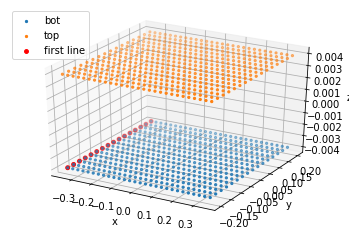

In [349]:
# Check selected nodes
fig,ax = plt.subplots(subplot_kw={'projection':'3d'})

ax.scatter(X[N_bot][:,0],X[N_bot][:,1],X[N_bot][:,2],s=5,label='bot') # undeformed
ax.scatter(X[N_top][:,0],X[N_top][:,1],X[N_top][:,2],s=5,label='top') # undeformed

tol = 1E-12
nodeline = np.argwhere(np.abs(X[N_bot][:,0] - X[N_bot][:,0].min()) < tol).ravel() # Node indices of bottom nodes 


ax.scatter(X[N_bot][nodeline][:,0],X[N_bot][nodeline][:,1],X[N_bot][nodeline][:,2],s=15, c='r', label='first line') # undeformed

print(Iz[N_bot][nodeline])

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend()


In [350]:
from scipy.sparse.linalg import spsolve
uc_constant = spsolve(Kc, load_constant_constrained)
u_constant = Q @ uc_constant
uc_linear = spsolve(Kc, load_linear_constrained)
u_linear = Q @ uc_linear

LOAD CHARACTERISTIC:
Total load: 1400.0 N
Area: 0.280 m^2
Calculated mean pressure: 5.000000000000001 kPa
Analytic mean pressure: p_max/2 = 5.0 kPa


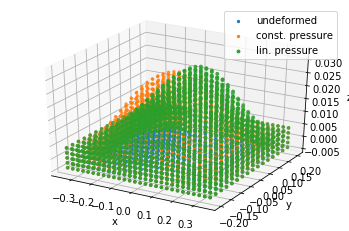

In [352]:
# Sanity check for load distribuation
print("LOAD CHARACTERISTIC:")
print(f"Total load: {load_linear.sum() :.1f} N")
print(f"Area: {area :.3f} m^2")
print(f"Calculated mean pressure: {load_linear.sum()/area/1000} kPa")
print(f"Analytic mean pressure: p_max/2 = {p_max/2/1000} kPa")

# Scatter plot
fig,ax = plt.subplots(subplot_kw={'projection':'3d'})

ax.scatter(X[:,0],X[:,1],X[:,2],s=5,label='undeformed') # undeformed

# format U like X
U_constant = np.array([u_constant[Ix],u_constant[Iy],u_constant[Iz]]).T
U_linear = np.array([u_linear[Ix],u_linear[Iy],u_linear[Iz]]).T

# scale factor for plotting
s = max(
    0.5/np.max(np.sqrt(np.sum(U_constant**2,axis=0))),
    0.5/np.max(np.sqrt(np.sum(U_linear**2,axis=0)))
    )

Xu_constant = X + s*U_constant # defomed configuration (displacement scaled by s)
Xu_linear = X + s*U_linear
ax.scatter(Xu_constant[:,0], Xu_constant[:,1], Xu_constant[:,2], s=5, label='const. pressure')
ax.scatter(Xu_linear[:,0], Xu_linear[:,1], Xu_linear[:,2], s=8, label='lin. pressure')
#ax.scatter(Xu_diff[:,0], Xu_diff[:,1], Xu_diff[:,2], s=8, label='difference')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend()




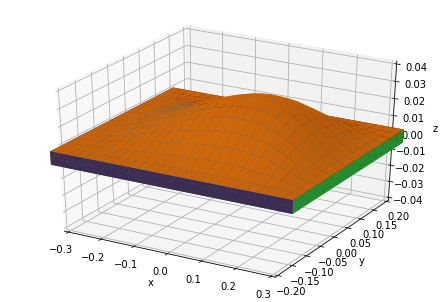

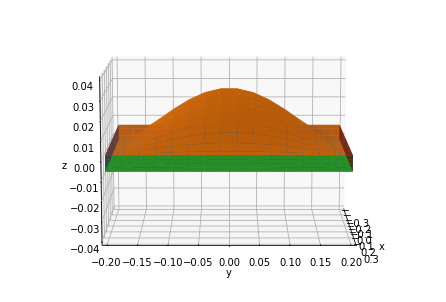

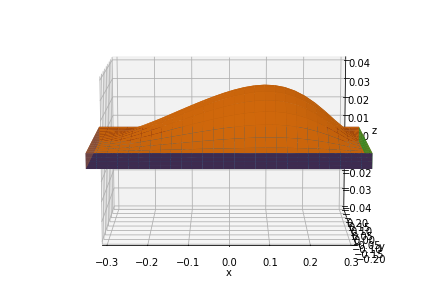

In [355]:
def plot_3d_deformation(X, u, elev=30.0, azim=60.0):

    # format U like X
    U = np.array([u[Ix],u[Iy],u[Iz]]).T
    s = 0.5/np.max(np.sqrt(np.sum(U**2,axis=0)))
    Xu = X + s*U_linear

    # Set up figure
    fig = plt.figure()
    ax = Axes3D(fig, elev=elev, azim=azim) 
    
    # Plot a basic wireframe.
    index = 1

    x_bot = np.reshape(Xu[N_bot,0],(len(y),len(x)))
    y_bot = np.reshape(Xu[N_bot,1],(len(y),len(x)))
    z_bot = np.reshape(Xu[N_bot,2],(len(y),len(x)))

    x_top = np.reshape(Xu[N_top,0],(len(y),len(x)))
    y_top = np.reshape(Xu[N_top,1],(len(y),len(x)))
    z_top = np.reshape(Xu[N_top,2],(len(y),len(x)))

    x_o = np.reshape(Xu[No,0],(len(y),len(z)))
    y_o = np.reshape(Xu[No,1],(len(y),len(z)))
    z_o = np.reshape(Xu[No,2],(len(y),len(z)))

    x_n = np.reshape(Xu[Nn,0],(len(x),len(z)))
    y_n = np.reshape(Xu[Nn,1],(len(x),len(z)))
    z_n = np.reshape(Xu[Nn,2],(len(x),len(z)))

    x_s = np.reshape(Xu[Ns,0],(len(x),len(z)))
    y_s = np.reshape(Xu[Ns,1],(len(x),len(z)))
    z_s = np.reshape(Xu[Ns,2],(len(x),len(z)))

    x_w = np.reshape(Xu[Nw,0],(len(y),len(z)))
    y_w = np.reshape(Xu[Nw,1],(len(y),len(z)))
    z_w = np.reshape(Xu[Nw,2],(len(y),len(z)))

    sf1 = ax.plot_surface(x_bot, y_bot, z_bot, rstride=index, cstride=index)
    sf2 = ax.plot_surface(x_top, y_top, z_top, rstride=index, cstride=index)
    sf3 = ax.plot_surface(x_o, y_o, z_o, rstride=index, cstride=index)
    sf4 = ax.plot_surface(x_n, y_n, z_n, rstride=index, cstride=index)
    sf5 = ax.plot_surface(x_s, y_s, z_s, rstride=index, cstride=index)
    sf6 = ax.plot_surface(x_w, y_w, z_w, rstride=index, cstride=index)

    ax.set_xlim(-0.3,0.3)
    ax.set_ylim(-0.2,0.2)
    ax.set_zlim(-0.04,0.04)

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    pass

plot_3d_deformation(X, u_constant, elev=30, azim=-60)
plot_3d_deformation(X, u_constant, elev=10, azim=0)
plot_3d_deformation(X, u_constant, elev=10, azim=-90)

Approximate the computed static displacement using the first three oscillation modes.
* What are the required modal coordinates?
* Plot the residual, which mode should you include to improve the approximation?

# Transient Solution

We'll investigate the plate in the same configuration as in Exercise 2, but now compute results using reduced order models.

One can use the Newmark time intragration both for the full system and in the modal coodinates.

### Forcing
Use the forcing given in Task 1 of Exercise 2: $f(t) = 1-e^{-(t/0.002)^2}$ in z-direction at $P_1= [0.2,0.12,0.003925]$.

### Damping
For the sake of simplicity assume Rayleigh damping with $\alpha=2.15$ and $\beta=3e-5$.

## Task 1: Transient Response using Reduced Model

Use a modal basis of the first two modes and compute the transient response of the system (under the same loading as in Task 1 of Exercise 2). Plot the response at points P1 and P2, and compare with the full system.
What is the error with respect to the full system?

### Choice of Modes
* How does the error improve when you take more modes?
* Plot the response at selected nodes, e.g. N1, N2, center, for different models in the same graph.

### Time Evolution of Modal Corrdinates
* Visualize the time evolution of the used modal coordinates
* Do this for the results obtained with differnt modal bases
* Compute the modal contributions in the same way. Which modes contribute most for which model?

# Steady State Oscillation | Frequency Domain

Now switch to frequency domain and compute the steady state response of the system.
For the sake of simplicity use a unit excitation at $P_1$.

## Task 2: Compute Harmonic Response using a Reduced Model

Use the first 10 modes to compute the steady state response for a unit forcing in z-direction at $P_1$.
Do the computation for Rayleigh damping and for Modal damping with a damping ratio of 0.01 for each mode.
Compare the results by plotting the transfer functions up to 300Hz.

### Compare damping models
* what is the difference between modal and Rayleigh damping?
* what happens if you only damp certain modes with modal damping?

### Modal contribution
* compute the modal contribution factors for each mode and plot them over the frequency
* When is which mode important?